# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price y una barrera adecuada.

Se habilitará un enlace en moodle para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(tickers, start_date=None, end_date=None, freq=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    if freq == None:
        freq = 'd'
    # Importamos paquetes necesarios
    import pandas as pd
    pd.core.common.is_list_like = pd.api.types.is_list_like
    import pandas_datareader.data as web  
    # Creamos DataFrame vacío de precios, con el índice de las fechas
    closes = pd.DataFrame(columns = tickers, index=web.YahooDailyReader(symbols=tickers[0], start=start_date, end=end_date, interval=freq).read().index)
    # Agregamos cada uno de los precios con YahooDailyReader
    for ticker in tickers:
        df = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date, interval=freq).read()
        closes[ticker]=df['Adj Close']
    closes.index_name = 'Date'
    closes = closes.sort_index()
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [3]:
closes = get_closes(['MSFT'], '2017-01-01')
closes_msft = closes.loc[:,'MSFT']

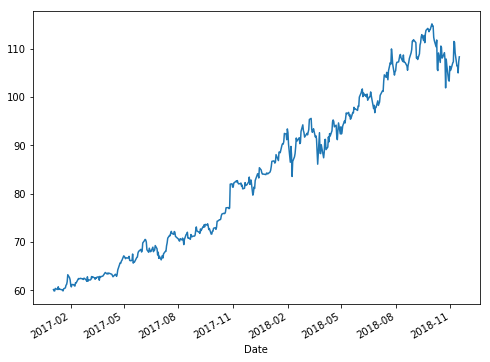

In [4]:
closes_msft.plot(figsize=(8,6));

In [5]:
ret_msft = calc_daily_ret(closes_msft)

In [6]:
msft = web.YahooOptions('MSFT')
msft_opt = msft.get_all_data().reset_index()
msft_opt.set_index('Expiry').sort_index()

,Strike,Type,Symbol,...,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,
2018-11-23,99.0,call,MSFT181123C00099000,...,2018-11-16 21:00:01,2018-11-15 17:29:34,"{'contractSymbol': 'MSFT181123C00099000', 'str..."
2018-11-23,87.5,put,MSFT181123P00087500,...,2018-11-16 21:00:01,2018-11-01 18:33:35,"{'contractSymbol': 'MSFT181123P00087500', 'str..."
2018-11-23,113.0,put,MSFT181123P00113000,...,2018-11-16 21:00:01,2018-11-16 20:26:47,"{'contractSymbol': 'MSFT181123P00113000', 'str..."
2018-11-23,113.0,call,MSFT181123C00113000,...,2018-11-16 21:00:01,2018-11-16 20:47:41,"{'contractSymbol': 'MSFT181123C00113000', 'str..."
2018-11-23,88.5,put,MSFT181123P00088500,...,2018-11-16 21:00:01,2018-11-14 19:02:07,"{'contractSymbol': 'MSFT181123P00088500', 'str..."
...,...,...,...,...,...,...,...
2021-01-15,95.0,call,MSFT210115C00095000,...,2018-11-16 21:00:01,2018-11-14 20:09:28,"{'contractSymbol': 'MSFT210115C00095000', 'str..."
2021-01-15,95.0,put,MSFT210115P00095000,...,2018-11-16 21:00:01,2018-11-15 19:00:17,"{'contractSymbol': 'MSFT210115P00095000', 'str..."
2021-01-15,135.0,call,MSFT210115C00135000,...,2018-11-16 21:00:01,2018-11-16 14:30:53,"{'contractSymbol': 'MSFT210115C00135000', 'str..."


In [7]:
opt_deseada = msft_opt.loc[(msft_opt.Type=='call') & (msft_opt.Strike==120) & (msft_opt.Expiry=='2019-01-18')]
opt_deseada

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
463,120.0,2019-01-18,call,...,2018-11-16 21:00:01,2018-11-16 20:45:03,"{'contractSymbol': 'MSFT190118C00120000', 'str..."


In [8]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            120
Expiry                                            2019-01-18 00:00:00
Type                                                             call
Symbol                                            MSFT190118C00120000
Last                                                              0.9
                                          ...                        
Underlying                                                       MSFT
Underlying_Price                                                  108
Quote_Time                                        2018-11-16 21:00:01
Last_Trade_Date                                   2018-11-16 20:45:03
JSON                {'contractSymbol': 'MSFT190118C00120000', 'str...
Name: 463, Length: 19, dtype: object

In [9]:
opt_valuar['JSON']

{'contractSymbol': 'MSFT190118C00120000',
 'strike': 120.0,
 'currency': 'USD',
 'lastPrice': 0.9,
 'change': -0.050000012,
 'percentChange': -5.2631593,
 'volume': 610,
 'openInterest': 28370,
 'bid': 0.75,
 'ask': 1.0,
 'contractSize': 'REGULAR',
 'expiration': 1547769600,
 'lastTradeDate': 1542401103,
 'impliedVolatility': 0.24927508544921873,
 'inTheMoney': False}

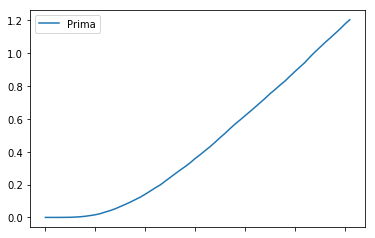

In [10]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.0272/360
K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ndays = (opt_valuar.Expiry.date()-datetime.today().date()).days
nscen = 100000
dates = pd.date_range(datetime.today().date(),periods=ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call.plot();

In [11]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(1.1327349909678444, 1.2736124413432863)


# 1.-Valuacion de una opcion CALL down and out


* Down-and-out call: Sí $S_0>B$, $C_t^{do}=\max\{S_T-K,0\}I(S_t>B)$



## 1.1 Metodo de rendimientos normales


In [12]:
B = 110    # Precio barrera
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes<barrier).cumsum()>0

,0,1,2,...,99997,99998,99999
2018-11-17,True,True,True,...,True,True,False
2018-11-18,True,True,True,...,True,True,False
2018-11-19,True,True,True,...,True,True,False
2018-11-20,True,True,True,...,True,True,False
2018-11-21,True,True,True,...,True,True,False
...,...,...,...,...,...,...,...
2019-01-13,True,True,True,...,True,True,True
2019-01-14,True,True,True,...,True,True,True
2019-01-15,True,True,True,...,True,True,True
2019-01-16,True,True,True,...,True,True,True


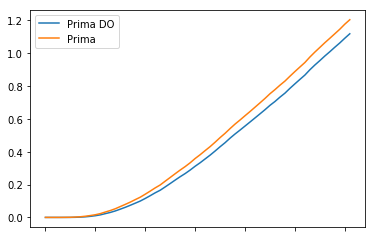

In [13]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
calldo = pd.DataFrame({'Prima Down-and-Out':np.exp(-r*ndays)*(I*np.fmax(sim_closes-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = calldo.plot();
call.plot(ax=ax);

## 1.2.-Metodo del histograma

In [14]:
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [15]:
K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ndays = (opt_valuar.Expiry.date()-datetime.today().date()).days
nscen = 100000
dates = pd.date_range(datetime.today().date(),periods=ndays).astype('str')

ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret,index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

In [16]:
B = 110    # Precio barrera
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes_hist<barrier).cumsum()>0

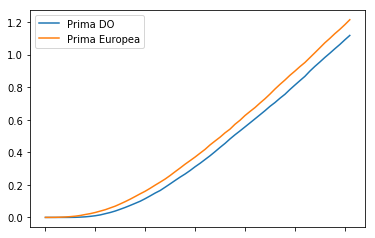

In [17]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros((ndays,nscen))).T.mean()},index=dates)
calldo = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I*np.fmax(sim_closes_hist-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = calldo.plot();
call.plot(ax=ax);

# 2.-Valuacion de opcion PUT up and out

* Down-and-out put: Sí $S_0>B$, $P_t^{do}=\max\{K-S_T,0\}I(S_t>B)$



In [18]:
opt_deseada = msft_opt.loc[(msft_opt.Type=='put') & (msft_opt.Strike==100) & (msft_opt.Expiry=='2019-01-18')]
opt_deseada

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
306,100.0,2019-01-18,put,...,2018-11-16 21:00:01,2018-11-16 20:52:32,"{'contractSymbol': 'MSFT190118P00100000', 'str..."


In [19]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            100
Expiry                                            2019-01-18 00:00:00
Type                                                              put
Symbol                                            MSFT190118P00100000
Last                                                             1.81
                                          ...                        
Underlying                                                       MSFT
Underlying_Price                                                  108
Quote_Time                                        2018-11-16 21:00:01
Last_Trade_Date                                   2018-11-16 20:52:32
JSON                {'contractSymbol': 'MSFT190118P00100000', 'str...
Name: 306, Length: 19, dtype: object

In [20]:
opt_valuar['JSON']

{'contractSymbol': 'MSFT190118P00100000',
 'strike': 100.0,
 'currency': 'USD',
 'lastPrice': 1.81,
 'change': -0.3800001,
 'percentChange': -17.351604,
 'volume': 328,
 'openInterest': 28781,
 'bid': 1.75,
 'ask': 1.92,
 'contractSize': 'REGULAR',
 'expiration': 1547769600,
 'lastTradeDate': 1542401552,
 'impliedVolatility': 0.29077857666015616,
 'inTheMoney': False}

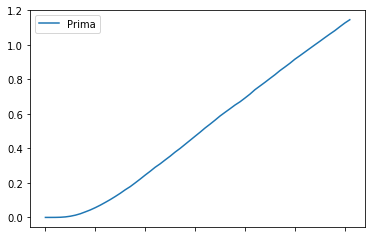

In [21]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.0272/360
K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ndays = (opt_valuar.Expiry.date()-datetime.today().date()).days
nscen = 100000
dates = pd.date_range(datetime.today().date(),periods=ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros([ndays,nscen])).T.mean()},index=dates)
put.plot();

In [27]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(1.0830687256274898, 1.2239100494796797)


## 2.1.- Metodo de rendimientos normales

In [22]:
B = 110    # Precio barrera
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes>barrier).cumsum()>0

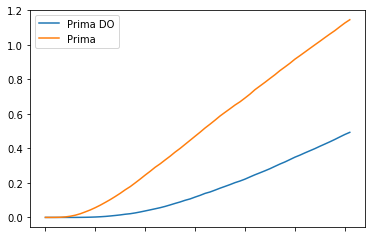

In [23]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
put=pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros([ndays,nscen])).T.mean()},index=dates)
putuo = pd.DataFrame({'Prima Up-and-Out':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = putuo.plot();
put.plot(ax=ax);

## 2.2.-Metodo del histograma

In [24]:
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)
K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ndays = (opt_valuar.Expiry.date()-datetime.today().date()).days
nscen = 100000
dates = pd.date_range(datetime.today().date(),periods=ndays).astype('str')

ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret,index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

In [25]:
B = 110    # Precio barrera
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes_hist>barrier).cumsum()>0

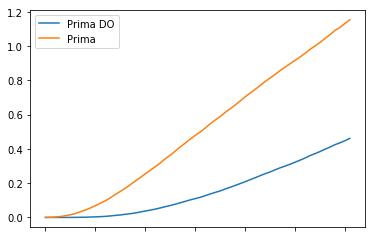

In [26]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
put=pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
putuo = pd.DataFrame({'Prima Up-and-Out':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes_hist,np.zeros((ndays,nscen)))).T.mean()},index=dates)
ax = putuo.plot();
put.plot(ax=ax);